In [1]:
import glob
import os
import json
import datetime
import time

import torch
import pandas as pd
import numpy as np
import nibabel as nib

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

#from fastai.vision.all import *
import fastMONAI.vision_all
from monai.networks.nets import UNet
from monai.losses import DiceCELoss
from scipy import interpolate

from useful_functions import *
from prostate import *

/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
bids_dir = "bids-new"

In [3]:
session_dirs = []
for json_path in sorted(glob.glob(os.path.join(bids_dir, "sub*", "ses*", "anat", "*echo-01*mag*json"))):
    with open(json_path, 'r') as json_file:
        json_data = json.load(json_file)
        if json_data['ProtocolName'] == "t2starME_qsm_tra_Iso1.4mm_INPHASE_bipolar_RUN_THIS_ONE":
            session_dirs.append(os.sep.join(os.path.split(json_path)[0].split(os.sep)[:-1]))
print(f"{len(session_dirs)} sessions found")
session_dirs

24 sessions found


['bids-new/sub-z0034542/ses-20220715',
 'bids-new/sub-z0182923/ses-20230705',
 'bids-new/sub-z0186251/ses-20221107',
 'bids-new/sub-z0237546/ses-20230508',
 'bids-new/sub-z0317485/ses-20230517',
 'bids-new/sub-z0445614/ses-20230510',
 'bids-new/sub-z0705200/ses-20230104',
 'bids-new/sub-z0755228/ses-20211108',
 'bids-new/sub-z1167038/ses-20220315',
 'bids-new/sub-z1181657/ses-20220315',
 'bids-new/sub-z1262112/ses-20220314',
 'bids-new/sub-z1472355/ses-20221222',
 'bids-new/sub-z1568577/ses-20230510',
 'bids-new/sub-z1571613/ses-20230519',
 'bids-new/sub-z1728751/ses-20220328',
 'bids-new/sub-z1778013/ses-20220715',
 'bids-new/sub-z1818796/ses-20230313',
 'bids-new/sub-z2007565/ses-20220715',
 'bids-new/sub-z2900812/ses-20230523',
 'bids-new/sub-z2904752/ses-20220826',
 'bids-new/sub-z2952003/ses-20230614',
 'bids-new/sub-z3171177/ses-20230313',
 'bids-new/sub-z3278008/ses-20211109',
 'bids-new/sub-z3393287/ses-20230524']

In [4]:
extra_files = sum((glob.glob(os.path.join(session_dir, "extra_data", "*.nii*")) for session_dir in session_dirs), [])

qsm_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "*qsm_echo2-and-echo4.*")) for session_dir in session_dirs), []))
t2s_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "*t2starmap.nii*")) for session_dir in session_dirs), []))
r2s_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "*r2starmap.nii*")) for session_dir in session_dirs), []))
mag_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "magnitude_combined.nii")) for session_dir in session_dirs), []))
swi_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "swi.nii")) for session_dir in session_dirs), []))

gre_seg_raw_files = [extra_file for extra_file in extra_files if all(pattern in extra_file for pattern in ['_segmentation.', 'run'])]
gre_seg_clean_files = [seg_file.replace(".nii", "_clean.nii") for seg_file in gre_seg_raw_files if os.path.exists(seg_file.replace(".nii", "_clean.nii"))]

t1_files = [extra_file for extra_file in extra_files if any(pattern in extra_file for pattern in ['_T1w', '_t1_tra']) and not any(pattern in extra_file for pattern in ['_Pelvis_', '.json', '_resampled'])]
t1_files = [t1_file.replace("_resampled", "") for t1_file in t1_files]
t1_resampled_files = [t1_file.replace(".nii", "_resampled.nii") for t1_file in t1_files if os.path.exists(t1_file.replace(".nii", "_resampled.nii"))]

ct_files = [extra_file for extra_file in extra_files if 'resliced' in extra_file and any(pattern in extra_file for pattern in ['_na_', '_Pelvis_', '_NA']) and not any(pattern in extra_file for pattern in ['_t1_tra_', 'ATX', 'AXT', 'ROI', 'segmentation', '.json'])]
ct_seg_raw_files = sum((glob.glob(ct_file.replace(".nii", "_segmentation.nii")) for ct_file in ct_files), [])
ct_seg_clean_files = [ct_file.replace("_segmentation", "_segmentation_clean") for ct_file in ct_seg_raw_files if os.path.exists(ct_file)]

print(f"{len(ct_files)} CT images found.")
print(f"{len(ct_seg_raw_files)} raw CT segmentations found.")
print(f"{len(ct_seg_clean_files)} clean CT segmentations found.")
print(f"{len(qsm_files)} QSM images found.")
print(f"{len(mag_files)} magnitude images found.")
print(f"{len(t2s_files)} T2* maps found.")
print(f"{len(r2s_files)} R2* maps found.")
print(f"{len(swi_files)} SWI maps found.")
print(f"{len(t1_files)} T1w files found.")
print(f"{len(t1_resampled_files)} resampled T1w files found.")
print(f"{len(gre_seg_raw_files)} raw GRE segmentations found.")
print(f"{len(gre_seg_clean_files)} clean GRE segmentations found.")

24 CT images found.
24 raw CT segmentations found.
24 clean CT segmentations found.
24 QSM images found.
24 magnitude images found.
24 T2* maps found.
24 R2* maps found.
24 SWI maps found.
24 T1w files found.
24 resampled T1w files found.
24 raw GRE segmentations found.
24 clean GRE segmentations found.


In [5]:
assert(len(qsm_files) == len(gre_seg_clean_files))
assert(len(qsm_files) == len(t2s_files))
assert(len(qsm_files) == len(r2s_files))
assert(len(qsm_files) == len(swi_files))
assert(len(qsm_files) == len(mag_files))
assert(len(qsm_files) == len(t1_resampled_files))
assert(len(ct_files) == len(ct_seg_clean_files))

In [6]:
model_data = {
    'CT' : { 'in_files' : [f"{ct_files[i]}" for i in range(len(ct_files))], 'seg_files': ct_seg_clean_files },
    'QSM-T1' : { 'in_files' : [f"{qsm_files[i]};{t1_resampled_files[i]}" for i in range(len(qsm_files))], 'seg_files': gre_seg_clean_files },
    'QSM-SWI' : { 'in_files' : [f"{qsm_files[i]};{swi_files[i]}" for i in range(len(qsm_files))], 'seg_files': gre_seg_clean_files },
    'QSM' : { 'in_files' : [f"{qsm_files[i]}" for i in range(len(qsm_files))], 'seg_files': gre_seg_clean_files },
    'SWI' : { 'in_files' : [f"{swi_files[i]}" for i in range(len(qsm_files))], 'seg_files': gre_seg_clean_files },
    'T1' : { 'in_files' : [f"{t1_resampled_files[i]}" for i in range(len(qsm_files))], 'seg_files': gre_seg_clean_files },
    'T2s' : { 'in_files' : [f"{t2s_files[i]}" for i in range(len(qsm_files))], 'seg_files': gre_seg_clean_files },
    'R2s' : { 'in_files' : [f"{r2s_files[i]}" for i in range(len(qsm_files))], 'seg_files': gre_seg_clean_files },
    'GRE' : { 'in_files' : [f"{mag_files[i]}" for i in range(len(qsm_files))], 'seg_files': gre_seg_clean_files },
}

colors = {
    'CT' : '#a6cee3',
    'QSM-T1' : '#1f78b4',
    'QSM-SWI' : '#b2df8a',
    'QSM' : '#33a02c',
    'T1' : '#fb9a99',
    'SWI' : '#e31a1c',
    'GRE' : '#fdbf6f',
    'T2s' : '#ff7f00',
    'R2s' : '#cab2d6',
}

In [7]:
model_name = 'QSM'
k_folds = 24
random_state = 42
timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d-%H%M%S')

batch_size = 6
training_epochs = 700
lr = 0.003
ce_loss_weights = torch.Tensor([1, 1, 1])
evaluation_augmentations = [
    fastMONAI.vision_all.PadOrCrop([80, 80, 80]),
    fastMONAI.vision_all.ZNormalization(),
]

=== CT ===


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


=== QSM-T1 ===


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


=== QSM-SWI ===


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


=== QSM ===


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


=== SWI ===


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


=== T1 ===


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


=== T2s ===


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


=== R2s ===


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


=== GRE ===


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastMONAI/vision_metrics.py:49: RuntimeWarning: Mean of empty slice
  binary_dice_scores.append(np.nanmean(dsc)) #TODO update torch to get torch.nanmean() to work
/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


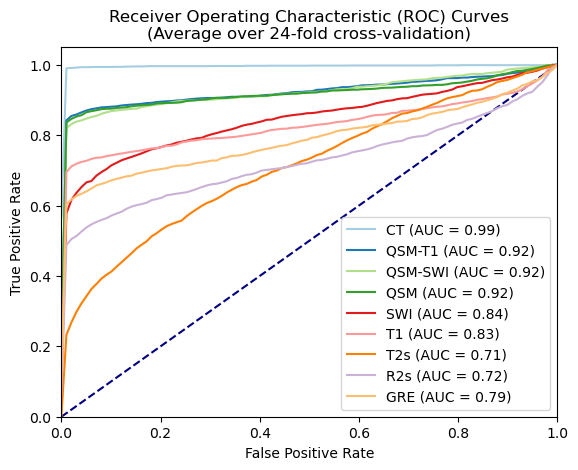

{'CT': [0.9520833333333334, 0.1103773514912467], 'QSM-T1': [0.827579365079365, 0.19042275622859559], 'QSM-SWI': [0.821875, 0.21212947680733943], 'QSM': [0.8423611111111112, 0.16336870129167458], 'SWI': [0.5174603174603174, 0.3302104755695418], 'T1': [0.7104166666666667, 0.20854503133038818], 'T2s': [0.21180555555555558, 0.37343745964409103], 'R2s': [0.5763888888888888, 0.3348893082280055], 'GRE': [0.6409722222222222, 0.28899487238605476]}
{'CT': [1.0, 0.0], 'QSM-T1': [0.9027777777777777, 0.17948399976833454], 'QSM-SWI': [0.8888888888888888, 0.15713484026367724], 'QSM': [0.9027777777777777, 0.1515098904810516], 'SWI': [0.5694444444444444, 0.35328048172158066], 'T1': [0.8194444444444443, 0.23529269925135302], 'T2s': [0.125, 0.2110928354662592], 'R2s': [0.5277777777777778, 0.2873355675774611], 'GRE': [0.6666666666666666, 0.3042903097250923]}
{'CT': [0.9070697, 0.024424968, nan, nan], 'QSM-T1': [0.6132769, 0.097477436, nan, nan], 'QSM-SWI': [0.61329377, 0.09505429, nan, nan], 'QSM': [0.643

'\nplt.xlim([0.0, 1.0])\nplt.ylim([0.0, 1.05])\nplt.xlabel(\'Recall\')\nplt.ylabel(\'Precision\')\nplt.title(\'Precision-Recall Curves\n(Average over 24-fold cross-validation)\')\n#plt.legend(loc="lower right")\nplt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))\nplt.tight_layout()  # to ensure that all the elements fit into the figure area\nplt.savefig("poc-curves-marker.png", dpi=400)\nplt.show()\n'

In [8]:
plt.figure()
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
model_marker_precisions = {}
model_marker_recalls = {}
losses = {}
for model in model_data.keys():

    print(f"=== {model} ===")

    # split training/testing
    df = pd.DataFrame(model_data[model])

    if model == 'CT':
        # determine resampling suggestion
        med_dataset = fastMONAI.vision_all.MedDataset(
            img_list=df.seg_files.tolist(),
            dtype=fastMONAI.vision_all.MedMask
        )
        suggested_voxelsize, requires_resampling = med_dataset.suggestion()
        largest_imagesize = med_dataset.get_largest_img_size(resample=suggested_voxelsize)

    # k validation folds
    kf = KFold(n_splits=k_folds, random_state=random_state, shuffle=True)

    marker_precisions = []
    marker_recalls = []
    precisions = []
    recalls = []
    fprs = []
    tprs = []
    fm_losses = []
    calc_losses = []

    for i, (train_index, valid_index) in enumerate(kf.split(df)):
        dblock = fastMONAI.vision_all.MedDataBlock(
            blocks=(fastMONAI.vision_all.ImageBlock(cls=fastMONAI.vision_all.MedImage), fastMONAI.vision_all.MedMaskBlock),
            splitter=fastMONAI.vision_all.IndexSplitter(valid_index),
            get_x=fastMONAI.vision_all.ColReader('in_files'),
            get_y=fastMONAI.vision_all.ColReader('seg_files'),
            item_tfms=evaluation_augmentations,
            reorder=requires_resampling,
            resample=suggested_voxelsize
        )

        dls = fastMONAI.vision_all.DataLoaders.from_dblock(dblock, df, bs=batch_size)

        n_input_channels = len(model_data[model]['in_files'][0].split(';'))
        learn = fastMONAI.vision_all.Learner(
            dls,
            model=UNet(
                spatial_dims=3,
                in_channels=n_input_channels,
                out_channels=3,
                channels=(16, 32, 64, 128, 256),
                strides=(2, 2, 2, 2),
                num_res_units=2
            ),
            loss_func=DiceCELoss(
                to_onehot_y=True,
                include_background=True,
                softmax=True,
                ce_weight=ce_loss_weights
            ),
            opt_func=fastMONAI.vision_all.ranger,
            metrics=[fastMONAI.vision_all.multi_dice_score, MarkersIdentified(), SuperfluousMarkers()]#.to_fp16()
        )

        model_file = glob.glob(f"models/{model}-2023*-*-{i}-best*")[0].replace('models/', '').replace('.pth', '')
        learn = learn.load(model_file)

        learn.model.cuda()

        # Compute metrics on the entire training dataset
        correct_markers = MarkersIdentified()

        dblock_valid_eval = fastMONAI.vision_all.MedDataBlock(
            blocks=(fastMONAI.vision_all.ImageBlock(cls=fastMONAI.vision_all.MedImage), fastMONAI.vision_all.MedMaskBlock),
            splitter=fastMONAI.vision_all.IndexSplitter([]),
            get_x=fastMONAI.vision_all.ColReader('in_files'),
            get_y=fastMONAI.vision_all.ColReader('seg_files'),
            item_tfms=evaluation_augmentations,
            reorder=requires_resampling,
            resample=suggested_voxelsize
        )
        dls_valid_eval = fastMONAI.vision_all.DataLoaders.from_dblock(dblock_valid_eval, df.iloc[valid_index], bs=1, sampler=fastMONAI.vision_all.SequentialSampler)
        for x, y in dls_valid_eval.train:
            pred = torch.argmax(learn.model(x), dim=1).unsqueeze(1).to(dtype=torch.float)
            correct_markers.accumulate(pred=pred.cpu(), targ=y.cpu())

        marker_tps = correct_markers.overlap_count
        marker_fps = correct_markers.pred_marker_count - correct_markers.overlap_count
        marker_fns = correct_markers.targ_marker_count - correct_markers.overlap_count

        marker_precision = (marker_tps / (marker_tps + marker_fps)) if (marker_tps + marker_fps) > 0 else 0
        marker_recall = (marker_tps / (marker_tps + marker_fns))  if (marker_tps + marker_fns) > 0 else 0
        marker_precisions.append(marker_precision)
        marker_recalls.append(marker_recall)

        loss, *metrics = learn.validate(ds_idx=0, dl=dls_valid_eval.train)
        fm_losses.append(metrics[0][0])
        calc_losses.append(metrics[0][1])

        # get predictions
        dls_valid_eval = fastMONAI.vision_all.DataLoaders.from_dblock(dblock_valid_eval, df.iloc[valid_index], bs=len(dls_valid_eval.train_ds), sampler=fastMONAI.vision_all.SequentialSampler)
        valid_x, valid_y = dls_valid_eval.train.one_batch()

        def calc_stuff(x, y):
            pred = learn.model(x)[:,1,:,:,:].unsqueeze(1).cpu().detach().numpy()
            pred -= np.min(pred)
            pred /= np.max(pred)
            pred = pred.flatten()
            targ = (y.cpu() == 1).to(dtype=torch.int).detach().numpy().flatten()

            # calculate AUC
            sample_weight = compute_sample_weight(class_weight="balanced", y=targ, indices=None)
            fpr, tpr, thresholds = roc_curve(targ, pred, sample_weight=sample_weight)
            roc_auc = auc(fpr, tpr)

            # calculate precision-recall curve
            precision, recall, _ = precision_recall_curve(targ, pred)
            average_precision = average_precision_score(targ, pred)

            return fpr, tpr, precision, recall, thresholds, average_precision, roc_auc

        fpr, tpr, precision, recall, thresholds, average_tpr, roc_auc = calc_stuff(valid_x, valid_y)

        precisions.append(precision)
        recalls.append(recall)
        fprs.append(fpr)
        tprs.append(tpr)

    model_marker_precisions[model] = [np.mean(marker_precisions), np.std(marker_precisions)]
    model_marker_recalls[model] = [np.mean(marker_recalls), np.std(marker_recalls)]
    losses[model] = [np.mean(fm_losses), np.std(fm_losses), np.mean(calc_losses), np.std(calc_losses)]

    # define a common set of FPR values
    common_fpr = np.linspace(0, 1, 100)

    # initialize an empty array to hold the interpolated TPRs
    interpolated_tprs = []

    for tpr, fpr in zip(tprs, fprs):
        # interpolate the TPR values to the common FPR values
        interpolated_tpr = np.interp(common_fpr, fpr, tpr)
        
        # store the interpolated TPR
        interpolated_tprs.append(interpolated_tpr)

    # calculate the average TPR at each common FPR value
    average_tpr = np.mean(interpolated_tprs, axis=0)

    roc_auc = auc(common_fpr, average_tpr)

    # plot the average precision-recall curve
    plt.plot(common_fpr, average_tpr, color=colors[model], label=f'{model} (AUC = {round(roc_auc, 2)})')

    '''
    # define a common set of recall values
    common_recall = np.linspace(0, 1, 100)

    # initialize an empty array to hold the interpolated precisions
    interpolated_precisions = []

    for precision, recall in zip(precisions, recalls):
        # reverse the arrays because recall should be non-decreasing for interpolation
        precision = precision[::-1]
        recall = recall[::-1]

        # interpolate the precision values to the common recall values
        interpolated_precision = np.interp(common_recall, recall, precision)
        
        # store the interpolated precision
        interpolated_precisions.append(interpolated_precision)

    # calculate the average precision at each common recall value
    average_precision = np.mean(interpolated_precisions, axis=0)

    prc_auc = auc(common_recall, average_precision)

    # plot the average precision-recall curve
    plt.plot(common_recall, average_precision, color=colors[model], label=f'{model} (AUC = {round(prc_auc, 2)})')
    '''
    

    del learn, dls, dblock_valid_eval, dls_valid_eval, loss, metrics, valid_x, valid_y, correct_markers

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves\n(Average over 24-fold cross-validation)')
plt.legend(loc="lower right")
plt.savefig("roc-curves2.png", dpi=400)
plt.show()

print(model_marker_precisions)
print(model_marker_recalls)
print(losses)

'''
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves\n(Average over 24-fold cross-validation)')
#plt.legend(loc="lower right")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
plt.tight_layout()  # to ensure that all the elements fit into the figure area
plt.savefig("poc-curves-marker.png", dpi=400)
plt.show()
'''

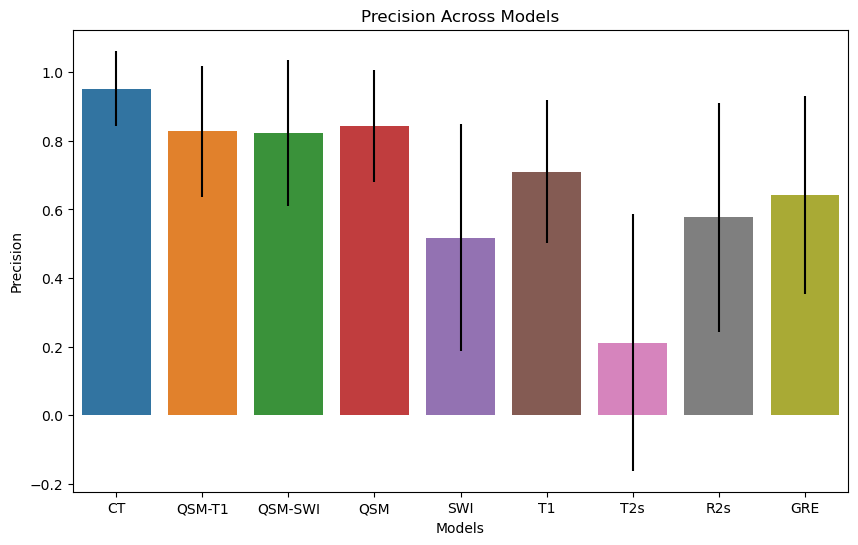

In [9]:
import seaborn as sns

# Convert the dictionary to a pandas dataframe
df = pd.DataFrame(model_marker_precisions).transpose().reset_index()
df.columns = ['Model', 'Mean', 'Std']

# Create a barplot using seaborn
plt.figure(figsize=(10,6))
sns.barplot(data=df, x='Model', y='Mean', yerr=df['Std'], capsize=.2)

plt.title('Precision Across Models')
plt.ylabel('Precision')
plt.xlabel('Models')
plt.show()

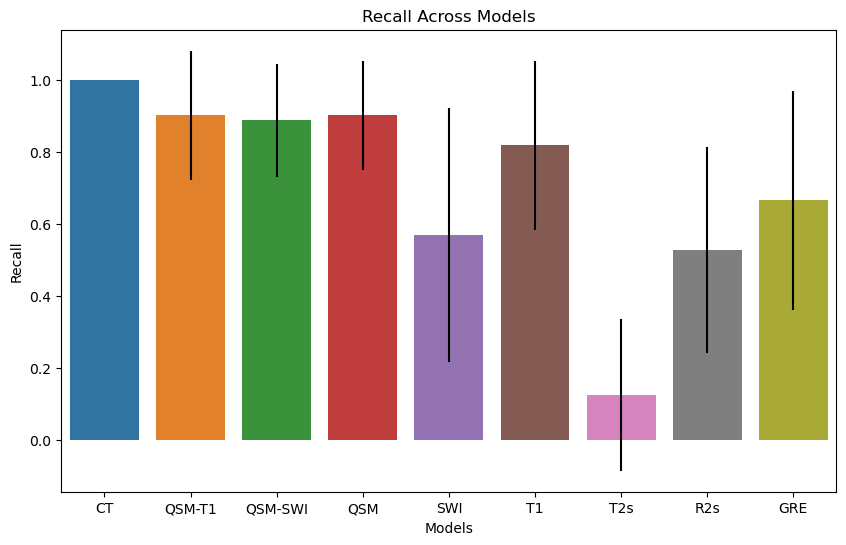

In [10]:
# Convert the dictionary to a pandas dataframe
df = pd.DataFrame(model_marker_recalls).transpose().reset_index()
df.columns = ['Model', 'Mean', 'Std']

# Create a barplot using seaborn
plt.figure(figsize=(10,6))
sns.barplot(data=df, x='Model', y='Mean', yerr=df['Std'], capsize=.2)

plt.title('Recall Across Models')
plt.ylabel('Recall')
plt.xlabel('Models')
plt.show()

In [11]:
# Convert the dictionary to a pandas dataframe
prec_df = pd.DataFrame(model_marker_precisions).transpose().reset_index()
rec_df = pd.DataFrame(model_marker_recalls).transpose().reset_index()

# Add Metric column to differentiate between Precision and Recall
prec_df['Metric'] = 'Precision'
rec_df['Metric'] = 'Recall'

prec_df.columns = ['Model', 'Mean', 'Std', 'Metric']
rec_df.columns = ['Model', 'Mean', 'Std', 'Metric']

# Combine both dataframes
df = pd.concat([prec_df, rec_df])

In [12]:
# Convert 'Mean' and 'Std' to the desired string format
df['Mean +/- Std'] = df.apply(lambda row: f'{round(row["Mean"], 2)} +/- {round(row["Std"], 2)}', axis=1)

# Pivot the table to get the desired format
df_pivot = df.pivot(index='Model', columns='Metric', values='Mean +/- Std').reset_index()

# Rename the columns to 'Recall' and 'Precision'
df_pivot.columns = ['Model', 'Precision', 'Recall']
df_pivot = df_pivot.sort_values('Precision', ascending=False)

In [13]:
df_pivot

,Model,Precision,Recall
0,CT,0.95 +/- 0.11,1.0 +/- 0.0
2,QSM,0.84 +/- 0.16,0.9 +/- 0.15
4,QSM-T1,0.83 +/- 0.19,0.9 +/- 0.18
3,QSM-SWI,0.82 +/- 0.21,0.89 +/- 0.16
7,T1,0.71 +/- 0.21,0.82 +/- 0.24
1,GRE,0.64 +/- 0.29,0.67 +/- 0.3
5,R2s,0.58 +/- 0.33,0.53 +/- 0.29
6,SWI,0.52 +/- 0.33,0.57 +/- 0.35
8,T2s,0.21 +/- 0.37,0.12 +/- 0.21


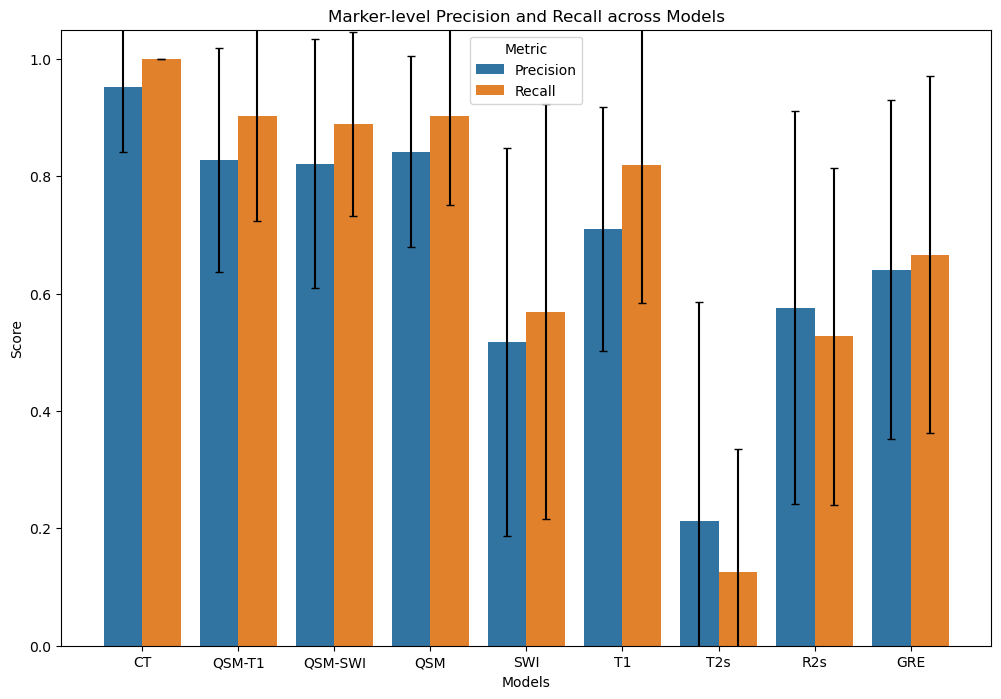

In [14]:
# Create a grouped barplot using seaborn
plt.figure(figsize=(12,8))
barplot = sns.barplot(data=df, x='Model', y='Mean', hue='Metric', capsize=.2)

# Add error bars manually
for i, model in enumerate(df['Model'].unique()):
    model_data = df[df['Model'] == model]
    precision_data = model_data[model_data['Metric'] == 'Precision']
    recall_data = model_data[model_data['Metric'] == 'Recall']
    barplot.errorbar(x=i - 0.2, y=precision_data['Mean'].values[0], yerr=precision_data['Std'].values[0], color='black', capsize=3)
    barplot.errorbar(x=i + 0.2, y=recall_data['Mean'].values[0], yerr=recall_data['Std'].values[0], color='black', capsize=3)

plt.ylim(0, 1.05)
plt.title('Marker-level Precision and Recall across Models')
plt.ylabel('Score')
plt.xlabel('Models')
plt.show()

In [ ]:
losses

In [ ]:
# Initialize lists to hold the data
model_list = []
region_list = []
mean_list = []
std_list = []

# Loop over the dictionary
for model, values in losses.items():
    # Add 'FM' region values
    model_list.append(model)
    region_list.append('FM')
    mean_list.append(values[0])
    std_list.append(values[1])
    
    # Add 'Calc' region values
    model_list.append(model)
    region_list.append('Calc')
    mean_list.append(values[2])
    std_list.append(values[3])

# Create the DataFrame
losses_df = pd.DataFrame({
    'Model': model_list,
    'Region': region_list,
    'Mean': mean_list,
    'Std': std_list
})
losses_df

In [ ]:
# Create a grouped barplot using seaborn
plt.figure(figsize=(12,8))
barplot = sns.barplot(data=losses_df, x='Model', y='Mean', hue='Region', capsize=.2)

# Add error bars manually
for i, model in enumerate(losses_df['Model'].unique()):
    for j, region in enumerate(losses_df['Region'].unique()):
        model_data = losses_df[losses_df['Model'] == model]
        model_data = model_data[model_data['Region'] == region]
        barplot.errorbar(x=i - 0.2 + 0.4*j, y=model_data['Mean'].values[0], yerr=model_data['Std'].values[0], color='black', capsize=3)

plt.ylim(0, 1.0)
plt.title('Dice scores across models and regions')
plt.ylabel('Dice score')
plt.xlabel('Models')
plt.show()

In [ ]:
pred_calc_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "*pred_calc.nii*")) for session_dir in session_dirs), []))
pred_seed_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "*pred_seed.nii*")) for session_dir in session_dirs), []))
pred_empty_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "*pred_empty.nii*")) for session_dir in session_dirs), []))
pred_seg_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "*pred_seg.nii*")) for session_dir in session_dirs), []))

assert(len(qsm_files) == len(pred_calc_files))
assert(len(qsm_files) == len(pred_seed_files))
assert(len(qsm_files) == len(pred_empty_files))
assert(len(qsm_files) == len(pred_seg_files))

In [ ]:
input_images = qsm_files
#input_segmentations = ct_seg_clean_files
#raw_segmentations = ct_seg_raw_files
input_segmentations = gre_seg_clean_files
raw_segmentations = gre_seg_raw_files
#clip_data = (0, 100)
clip_data = None
#vrange = (0, 1000) # T1w
#vrange = (0, 0.75) # SWI
vrange = (-0.5, +0.5) # QSM
#vrange = (0, 800) # GRE
crop_size = 20
half_cropsize = crop_size // 2

regions_vals = []
regions_masks = []
regions_pred_segs = []
regions_subjects = []
regions_pred_seeds = []
regions_pred_calcs = []

In [ ]:

for i in range(len(input_segmentations)):
    # load images
    subject = input_segmentations[i].split(os.sep)[1]
    seg = nib.load(input_segmentations[i]).get_fdata()
    input_data = nib.load(input_images[i]).get_fdata()
    pred_seg_data = nib.load(pred_seg_files[i]).get_fdata()
    pred_seed_data = nib.load(pred_seed_files[i]).get_fdata()
    pred_calc_data = nib.load(pred_calc_files[i]).get_fdata()

    if clip_data is not None:
        input_data[input_data == np.inf] = clip_data[1]
        input_data[input_data < 0] = clip_data[0]
        input_data[input_data > 100] = clip_data[1]
        input_data[np.isnan(input_data)] = 0

    # get regions
    centroids = get_centroids(mask=seg == SegTypeClean.GOLD_SEED.value)

    for j in range(len(centroids)):
        seg_submask = seg[
            centroids[j][0]-half_cropsize:centroids[j][0]+half_cropsize,
            centroids[j][1]-half_cropsize:centroids[j][1]+half_cropsize,
            centroids[j][2]-half_cropsize:centroids[j][2]+half_cropsize
        ]
        pred_seg_submask = pred_seg_data[
            centroids[j][0]-half_cropsize:centroids[j][0]+half_cropsize,
            centroids[j][1]-half_cropsize:centroids[j][1]+half_cropsize,
            centroids[j][2]-half_cropsize:centroids[j][2]+half_cropsize
        ]
        pred_seed_submask = pred_seed_data[
            centroids[j][0]-half_cropsize:centroids[j][0]+half_cropsize,
            centroids[j][1]-half_cropsize:centroids[j][1]+half_cropsize,
            centroids[j][2]-half_cropsize:centroids[j][2]+half_cropsize
        ]
        pred_calc_submask = pred_calc_data[
            centroids[j][0]-half_cropsize:centroids[j][0]+half_cropsize,
            centroids[j][1]-half_cropsize:centroids[j][1]+half_cropsize,
            centroids[j][2]-half_cropsize:centroids[j][2]+half_cropsize
        ]
        subvals = input_data[
            centroids[j][0]-half_cropsize:centroids[j][0]+half_cropsize,
            centroids[j][1]-half_cropsize:centroids[j][1]+half_cropsize,
            centroids[j][2]-half_cropsize:centroids[j][2]+half_cropsize
        ]
        regions_vals.append(subvals)
        regions_masks.append(seg_submask)
        regions_pred_segs.append(pred_seg_submask)
        regions_pred_seeds.append(pred_seed_submask)
        regions_pred_calcs.append(pred_calc_submask)
        regions_subjects.append(subject)

In [ ]:


print("Creating figure")
fig, axes = plt.subplots(ncols=4, nrows=len(regions_vals), figsize=(10, 180))

for ax in axes.flat:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

for i in range(len(regions_vals)):
    try:
        axes[i,0].imshow(regions_vals[i][regions_vals[i].shape[0]//2,:,:], cmap='gray', vmin=vrange[0], vmax=vrange[1], interpolation='nearest')
        
        axes[i,1].imshow(regions_vals[i][regions_vals[i].shape[0]//2,:,:], cmap='gray', vmin=vrange[0], vmax=vrange[1], interpolation='nearest')
        axes[i,1].imshow(regions_masks[i][regions_vals[i].shape[0]//2,:,:], cmap='tab10', alpha=np.array(regions_masks[i][regions_vals[i].shape[0]//2,:,:], dtype=float), vmin=1, vmax=9)

        axes[i,2].imshow(regions_vals[i][regions_vals[i].shape[0]//2,:,:], cmap='gray', vmin=vrange[0], vmax=vrange[1], interpolation='nearest')
        axes[i,2].imshow(regions_pred_segs[i][regions_vals[i].shape[0]//2,:,:], cmap='tab10', alpha=np.array(regions_pred_segs[i][regions_vals[i].shape[0]//2,:,:], dtype=float), vmin=1, vmax=9)

        axes[i,3].imshow(regions_vals[i][regions_vals[i].shape[0]//2,:,:], cmap='gray', vmin=vrange[0], vmax=vrange[1], interpolation='nearest')
        seed_alphamap = regions_pred_seeds[i][regions_vals[i].shape[0]//2,:,:] > 0
        calc_alphamap = regions_pred_calcs[i][regions_vals[i].shape[0]//2,:,:] > 0
        calc_alphamap = np.logical_and(calc_alphamap, calc_alphamap > seed_alphamap)
        calc_alphamap = np.logical_and(calc_alphamap, regions_pred_segs[i][regions_vals[i].shape[0]//2,:,:] != 2)
        axes[i,3].imshow(regions_pred_seeds[i][regions_vals[i].shape[0]//2,:,:], cmap='winter', alpha=np.array(seed_alphamap, dtype=float), vmin=0.01, vmax=15)
        axes[i,3].imshow(regions_pred_calcs[i][regions_vals[i].shape[0]//2,:,:], cmap='autumn', alpha=np.array(calc_alphamap, dtype=float), vmin=0.01, vmax=15)
    except:
        continue
    axes[i,0].set_ylabel(regions_subjects[i], rotation=0, fontsize=12, labelpad=55)

#print("Saving figure")
plt.savefig("seeds_qsm_preds.png", bbox_inches='tight', dpi=200)

print("Displaying figure")
plt.show()
plt.close()